In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=5a07837ae4a29133288b10789256bc266fff2e31bc65ec1ecabc0ddf42debf4c
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed

In [2]:
import os  # Importing the os module for interacting with the operating system
import random  # Importing the random module for generating random numbers
import numpy as np  # Importing NumPy for numerical operations
import torch  # Importing PyTorch, a deep learning framework
import torch.nn as nn  # Importing the nn module from PyTorch for building neural networks
import torch.optim as optim  # Importing optim module for optimization algorithms
import torch.nn.functional as F  # Importing functional interface of PyTorch for common functions
import torch.autograd as autograd  # Importing autograd module for automatic differentiation
from torch.autograd import Variable  # Importing Variable from autograd for tensor wrapper with gradient
from collections import deque, namedtuple  # Importing deque and namedtuple for specialized container datatypes

In [3]:
class Network(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)  # First fully connected layer with input size state_size and output size 64
        self.fc2 = nn.Linear(64, 64)  # Second fully connected layer with input size 64 and output size 64
        self.fc3 = nn.Linear(64, action_size)  # Third fully connected layer with input size 64 and output size action_size

    def forward(self, state):
        x = self.fc1(state)  # Pass input state through the first fully connected layer
        x = F.relu(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Pass through the second fully connected layer
        x = F.relu(x)  # Apply ReLU activation function
        return self.fc3(x)  # Return the output of the third fully connected layer

In [4]:
import gymnasium as gym # Importing the OpenAI Gym library for reinforcement learning environments

env = gym.make('LunarLander-v2')  # Creating the LunarLander environment
state_shape = env.observation_space.shape  # Getting the shape of the observation space
state_size = env.observation_space.shape[0]  # Getting the size of the observation space
number_actions = env.action_space.n  # Getting the number of possible actions
print('State shape: ', state_shape)  # Printing the shape of the observation space
print('State size: ', state_size)  # Printing the size of the observation space
print('Number of Actions: ', number_actions)  # Printing the number of possible actions

State shape:  (8,)
State size:  8
Number of Actions:  4


In [5]:
learning_rate = 5e-4  # Setting the learning rate for the neural network optimizer
minibatch_size = 1000  # Setting the size of minibatches for training
gamma = 0.99  # Setting the discount factor for future rewards
replay_buffer_size = 100000  # Setting the size of the replay buffer for experience replay
interpolation_parameter = 0.001  # Setting the interpolation parameter for updating target network parameters

In [6]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Setting the device for tensor operations
        self.capacity = capacity  # Setting the capacity of the replay memory
        self.memory = []  # Initializing an empty list for storing experiences

    def push(self, event):
        self.memory.append(event)  # Adding a new experience to the memory
        if len(self.memory) > self.capacity:  # Checking if memory capacity is exceeded
            del self.memory[0]  # Removing the oldest experience if capacity is exceeded

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)  # Sampling random experiences from memory
        # Extracting states, actions, rewards, next_states, and done flags from experiences and converting to tensors
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return states, next_states, actions, rewards, dones  # Returning the sampled experiences as tensors

In [7]:
class Agent():
    def __init__(self, state_size, action_size):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Setting the device for tensor operations
        self.state_size = state_size  # Setting the size of the state space
        self.action_size = action_size  # Setting the number of possible actions
        # Initializing local and target Q-networks, optimizer, replay memory, and time step counter
        self.local_qnetwork = Network(state_size, action_size).to(self.device)
        self.target_qnetwork = Network(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=learning_rate)  # Setting the optimizer
        self.memory = ReplayMemory(replay_buffer_size)  # Initializing replay memory
        self.t_step = 0  # Initializing time step counter

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))  # Storing experience in replay memory
        self.t_step = (self.t_step + 1) % 4  # Incrementing time step counter
        if self.t_step == 0:  # Updating network parameters every 4 steps
            if len(self.memory.memory) > minibatch_size:  # Checking if replay memory is sufficiently filled
                experiences = self.memory.sample(minibatch_size)  # Sampling experiences from memory
                self.learn(experiences, gamma)  # Updating Q-network parameters

    def act(self, state, epsilon=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  # Converting state to tensor
        self.local_qnetwork.eval()  # Setting the network to evaluation mode
        with torch.no_grad():
            action_values = self.local_qnetwork(state)  # Getting Q-values for the state
        self.local_qnetwork.train()  # Setting the network back to training mode
        if random.random() > epsilon:  # Choosing action based on epsilon-greedy policy
            return np.argmax(action_values.cpu().data.numpy())  # Selecting the action with maximum Q-value
        else:
            return random.choice(np.arange(self.action_size))  # Selecting a random action

    def learn(self, experiences, gamma):
        states, next_states, actions, rewards, dones = experiences  # Unpacking experiences
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)  # Getting target Q-values
        q_targets = rewards + (gamma * next_q_targets * (1 - dones))  # Calculating target Q-values
        q_expected = self.local_qnetwork(states).gather(1, actions)  # Getting predicted Q-values
        loss = F.mse_loss(q_expected, q_targets)  # Calculating the loss using mean squared error
        self.optimizer.zero_grad()  # Zeroing the gradients
        loss.backward()  # Backpropagating the loss
        self.optimizer.step()  # Taking a step with the optimizer
        self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)  # Updating target network parameters

    def soft_update(self, local_model, target_model, interpolation_parameter):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(interpolation_parameter * local_param.data + (1 - interpolation_parameter) * target_param.data)  # Soft updating target network parameters

In [8]:
agent = Agent(state_size, number_actions)  # Creating an instance of the Agent class with the state size and number of actions

In [9]:
number_episodes = 1000  # Setting the number of episodes for training
max_timesteps = 1000  # Setting the maximum number of timesteps per episode
epsilon_start = 1.0  # Setting the starting value of epsilon for epsilon-greedy exploration
epsilon_end = 0.01  # Setting the minimum value of epsilon
epsilon_decay = 0.995  # Setting the decay rate of epsilon
epsilon = epsilon_start  # Initializing epsilon
scores_on_100_episodes = deque(maxlen=100)  # Initializing a deque to store scores of last 100 episodes
losses = []  # Initializing a list to store the losses during training

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rewards_list = []  # Initialize rewards as a list

for episode in range(1, number_episodes + 1):  # Iterating over episodes
    state, _ = env.reset()  # Resetting the environment and getting initial state
    score = 0  # Initializing score for the episode

    for step in range(max_timesteps):  # Iterating over timesteps in the episode
        action = agent.act(state, epsilon)  # Selecting an action using epsilon-greedy policy
        next_state, reward, done, _, _ = env.step(action)  # Taking a step in the environment
        agent.step(state, action, reward, next_state, done)  # Updating agent's Q-network
        state = next_state  # Updating current state
        score += reward  # Updating the score
        if done:  # Checking if episode is done
            break

    scores_on_100_episodes.append(score)  # Appending episode score to the deque
    epsilon = max(epsilon_end, epsilon_decay * epsilon)  # Decaying epsilon
    if episode % 50 == 0:  # Printing average score and loss every 50 episodes
        avg_score = np.mean(scores_on_100_episodes)  # Calculating average score
        print('Episode {}\tAverage Score: {:.2f}'.format(episode, avg_score))  # Printing average score
        if len(scores_on_100_episodes) == 100:  # Checking if there are enough episodes for loss calculation
            avg_loss = np.mean(losses[-100:])  # Calculating average loss
            print('Episode {}\tAverage Loss: {:.2f}'.format(episode, avg_loss))  # Printing average loss
        else:
            print('Not enough data for loss calculation')

    # Calculate loss and append to losses list
    if len(scores_on_100_episodes) == 100:  # Checking if there are enough episodes for loss calculation
        experiences = agent.memory.sample(minibatch_size)  # Sampling experiences from replay memory
        states, next_states, actions, rewards, dones = experiences  # Unpacking experiences
        next_q_targets = agent.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)  # Getting target Q-values
        q_targets = rewards + (gamma * next_q_targets * (1 - dones))  # Calculating target Q-values
        q_expected = agent.local_qnetwork(states).gather(1, actions)  # Getting predicted Q-values
        loss = F.mse_loss(q_expected, q_targets)  # Calculating the loss using mean squared error
        losses.append(loss.item())  # Appending loss to the list

    rewards_list.append(score)  # Store reward for the episode

Episode 50	Average Score: -176.93
Not enough data for loss calculation
Episode 100	Average Score: -147.26
Episode 100	Average Loss: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 150	Average Score: -118.58
Episode 150	Average Loss: 30.35
Episode 200	Average Score: -99.07
Episode 200	Average Loss: 26.60
Episode 250	Average Score: -57.80
Episode 250	Average Loss: 18.38
Episode 300	Average Score: -37.38
Episode 300	Average Loss: 12.08


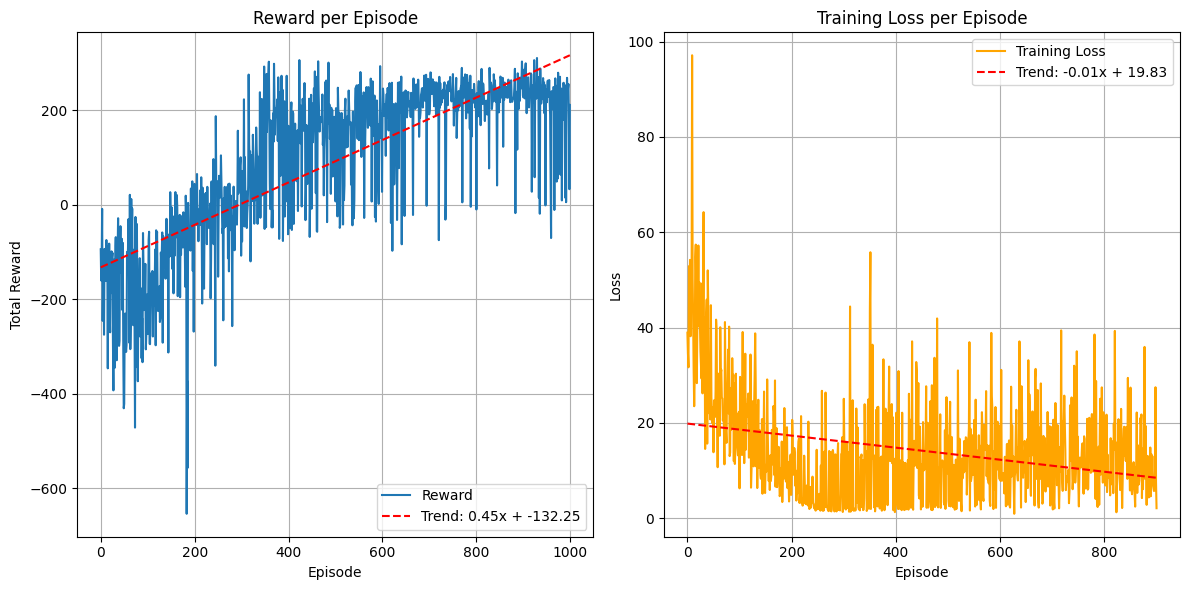

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the trend lines for reward and loss
reward_trend = np.polyfit(range(len(rewards_list)), rewards_list, 1)
loss_trend = np.polyfit(range(len(losses)), losses, 1)

# Plotting reward and loss
plt.figure(figsize=(12, 6))

# Plot reward
plt.subplot(1, 2, 1)
plt.plot(rewards_list, label='Reward')
plt.plot(np.polyval(reward_trend, range(len(rewards_list))), label=f'Trend: {reward_trend[0]:.2f}x + {reward_trend[1]:.2f}', color='red', linestyle='--')
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(losses, label='Training Loss', color='orange')
plt.plot(np.polyval(loss_trend, range(len(losses))), label=f'Trend: {loss_trend[0]:.2f}x + {loss_trend[1]:.2f}', color='red', linestyle='--')
plt.title('Training Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import glob  # Importing glob module for pathname pattern matching
import io  # Importing io module for handling file streams
import base64  # Importing base64 module for encoding and decoding binary data
import imageio  # Importing imageio module for reading and writing video files
from IPython.display import HTML, display  # Importing HTML and display functions from IPython.display module
import gym  # Importing OpenAI Gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder  # Importing VideoRecorder from Gym monitoring wrappers

def show_video_of_model(agent, env_name):
    env = gym.make(env_name)  # Creating the environment
    state, _ = env.reset()  # Resetting the environment and getting initial state
    done = False  # Initializing done flag
    frames = []  # Initializing a list to store frames of the video
    while not done:  # Looping until episode is done
        frame = env.render(mode='rgb_array')  # Rendering the current frame of the environment
        frames.append(frame)  # Appending the frame to the list of frames
        action = agent.act(state)  # Selecting an action using the agent's policy
        state, reward, done, _, _ = env.step(action.item())  # Taking a step in the environment
    env.close()  # Closing the environment
    imageio.mimsave('video.mp4', frames, fps=30)  # Saving the frames as a video file

show_video_of_model(agent, 'LunarLander-v2')  # Generating video for the agent's performance in LunarLander-v2 environment

def show_video():
    mp4list = glob.glob('*.mp4')  # Finding all video files in the current directory
    if len(mp4list) > 0:  # Checking if there are video files
        mp4 = mp4list[0]  # Selecting the first video file
        video = io.open(mp4, 'r+b').read()  # Reading the video file as binary data
        encoded = base64.b64encode(video)  # Encoding the binary data as base64
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))  # Displaying the video using HTML5 video tag
    else:
        print("Could not find video")  # Printing a message if no video file is found

show_video()  # Displaying the video

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
